In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import subprocess
import numpy as np
import uproot
import sys
import awkward as ak
from scipy.signal import find_peaks
import mplhep as hep
from scipy.optimize import curve_fit

hep.style.use('ATLAS')  # or ATLAS/LHCb2

def gaussian(x, amplitude, mean, stddev):
    return amplitude * np.exp(-(x - mean)**2 / (2 * stddev**2))

In [2]:
arg = 'rec.mu2e.CRV_wideband_cosmics.CRVWB-000-001-000.root'
# Execute the shell script with argument
filelist = subprocess.check_output(['./getDataset.sh', arg], universal_newlines=True)
filelist = filelist.splitlines()

In [3]:
goodruns=[1370] # Select LED runs with bias set to 0x600, 0x680, 0x700 and 0x780
goodruns=[str(x).zfill(6) for x in goodruns]

def select_good_runs(goodruns, allruns):
    return [item for item in allruns if any(goodruns in item for goodruns in goodruns)]
good_run_list=select_good_runs(goodruns, filelist)

In [4]:
good_run_list_xroot=[]
for root_file in good_run_list:
    root_file = 'root://fndca1.fnal.gov'+root_file[:5]+'/fnal.gov/usr/'+root_file[6:]            
    good_run_list_xroot.append(root_file)

In [10]:
file_list = ["{}{}".format(i,":run") for i in good_run_list_xroot]
arr = uproot.concatenate(file_list, 
                         filter_name=["time", "PEs", "temperature", "beta", "febID"], 
#                         filter_name=["PEs"], 
                         xrootdsource={"timeout": 1000})

In [141]:
cut = ak.all(ak.sum(arr['PEs'], axis=-1)>300, axis=-1)
arr_shower = arr[cut]

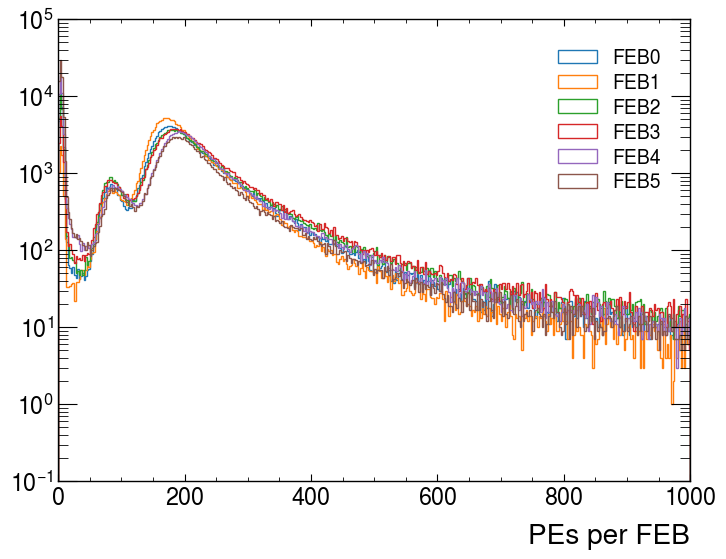

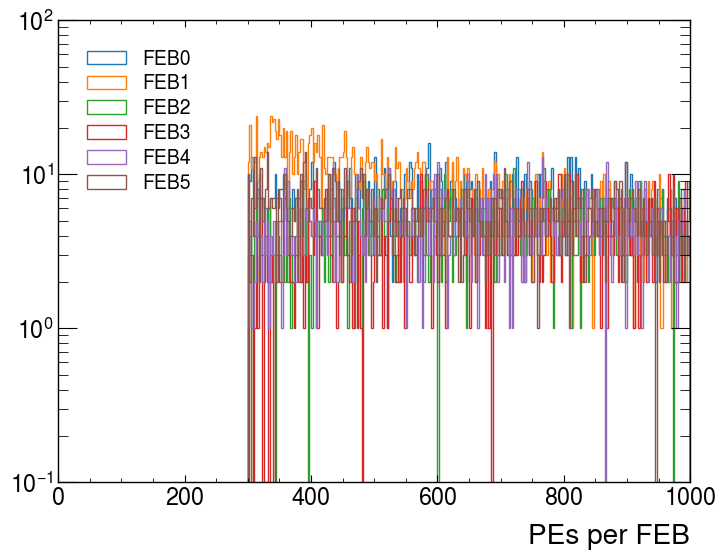

In [142]:
for feb in range(0,6):
    plt.hist(ak.sum(arr[:,feb]['PEs'], axis=-1), range=(0,1000), bins=400, histtype='step', label='FEB%d'%(feb));
plt.legend()
plt.yscale('log')
plt.xlabel("PEs per FEB");

plt.figure()
for feb in range(0,6):
    plt.hist(ak.sum(arr_shower[:,feb]['PEs'], axis=-1), range=(0,1000), bins=400, histtype='step', label='FEB%d'%(feb));
plt.legend()
plt.yscale('log')
plt.xlabel("PEs per FEB");

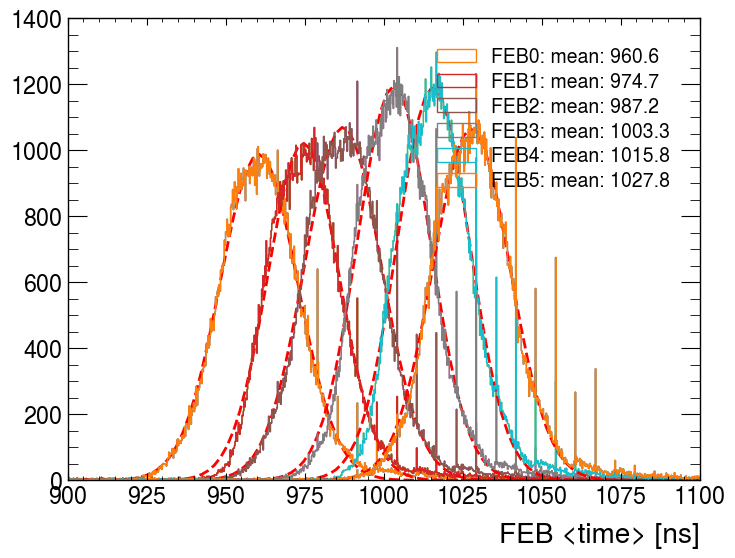

In [143]:
time_offsets=[]
for feb in range(0,6):
    hist, bins, _ = plt.hist(ak.flatten(arr_shower['time'][:,feb]), histtype='step', range=(900, 1100), bins=1000);
    
    # Calculate the bin centers
    bin_centers = (bins[:-1] + bins[1:]) / 2

    # Perform Gaussian fit
    initial_guess = [8000, 950, 10]  # Initial parameter guess
    params, _ = curve_fit(gaussian, bin_centers, hist, p0=initial_guess)

    # Extract the fitted parameters
    amplitude_fit, mean_fit, stddev_fit = params
    
    # Generate the fitted Gaussian curve
    curve_x = np.linspace(bins[0], bins[-1], 100)
    curve_y = gaussian(curve_x, amplitude_fit, mean_fit, stddev_fit)
    
    plt.plot(curve_x, curve_y, 'r--')
    plt.hist(ak.flatten(arr_shower['time'][:,feb]), histtype='step', range=(900, 1100), bins=1000, label='FEB%d: mean: %.1f'%(feb, mean_fit));
    plt.xlabel('FEB <time> [ns]')
    time_offsets.append(mean_fit)
    
plt.legend();

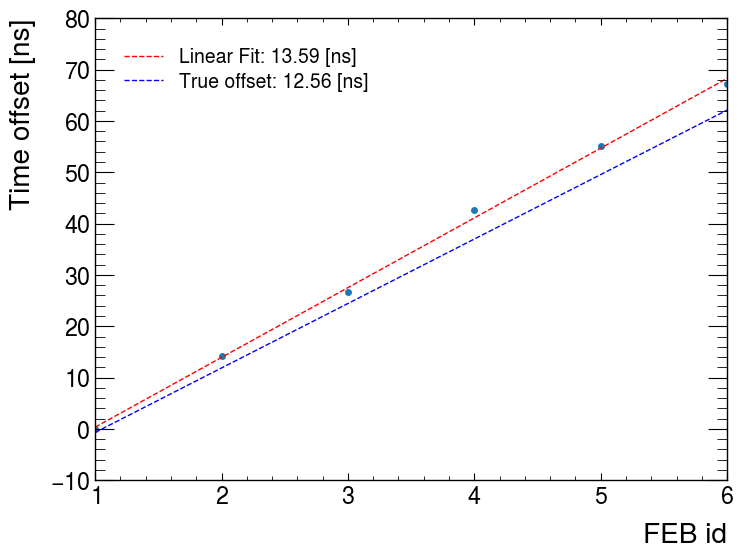

In [144]:
y=time_offsets-time_offsets[0]
x=range(1,len(y)+1)

plt.plot(x, y, '.');
m, b = np.polyfit(x, y, deg=1)

line = m * x + b
plt.plot(x, line, '--r', linewidth=1, label='Linear Fit: %0.2f [ns]'%m)
plt.xlabel('FEB id')
plt.ylabel("Time offset [ns]")

m = np.float64(12.56)
line = m*x + b
plt.plot(x, line, '--b', linewidth=1, label='True offset: %0.2f [ns]'%m)
plt.legend();


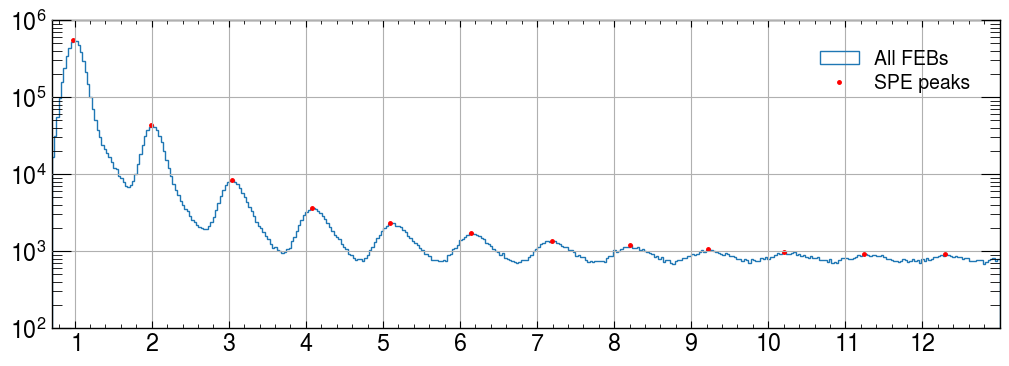

In [6]:
maxx=13
fig = plt.figure(figsize=[12,4])
ax = fig.gca()
ax.set_xticks(np.arange(0, maxx, 1))
#plt.hist(ak.flatten(arr['PEs'][:,0]), histtype='step', bins=800, range=(0.7, maxx), label="FEB1"); #FEB1
hist, bins, _ = plt.hist(ak.flatten(ak.flatten(arr['PEs'])), histtype='step', bins=400, range=(0.7, maxx), label="All FEBs"); #FEB0
peaks, _ = find_peaks(hist, width=5)
plt.plot(bins[peaks], hist[peaks], "r.", markersize=5, label="SPE peaks")

plt.yscale('log')
plt.grid()
plt.legend();

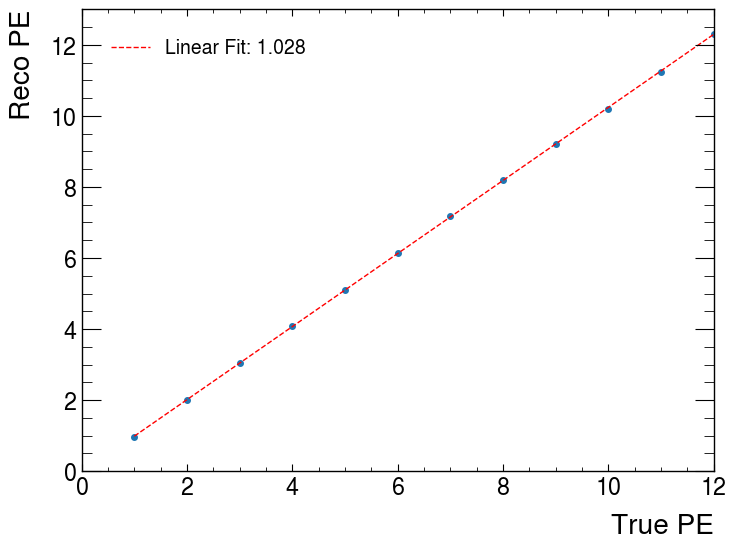

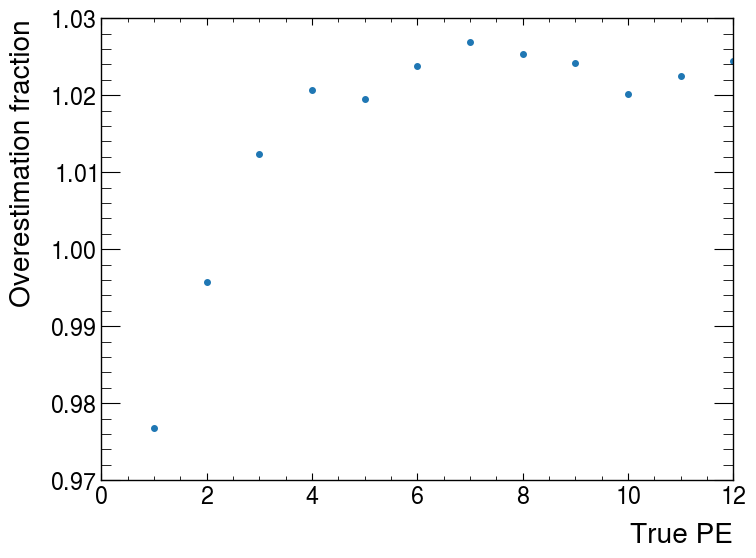

In [7]:
y=bins[peaks]
x=range(1,len(y)+1)
plt.plot(x, y, '.');
m, b = np.polyfit(x, y, deg=1)

line = m * x + b
plt.plot(x, line, '--r', linewidth=1, label='Linear Fit: %0.3f'%m)
plt.xlabel("True PE")
plt.ylabel("Reco PE")
plt.legend();
plt.ylim(0,maxx)

plt.figure()
plt.plot(x, y/x, '.');
plt.xlabel("True PE")
plt.ylabel("Overestimation fraction");
